In [46]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# modeling
from keras.utils import pad_sequences
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import keras

sns.set()

## Alteratine 1: Network Structure Change 

In [47]:
# Expects: run the code on lstm_traffic_only_1 to generate the csv info

traffic_df = pd.read_csv("../data/traffic_pre_lstm.csv")
traffic_df['timestamp'] = pd.to_datetime(traffic_df['timestamp'])
traffic_df.set_index('timestamp', inplace=True)
traffic_df.head()

,610,611,612,613,614,615,616,617,618,619,...,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,16.0,20.0,21.0,50.0,19.0,48.0,34.0,0.0,65.0,32.000000
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,69.0,34.0,0.0,69.0,32.000000
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,70.0,36.0,0.0,67.0,28.000000
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,22.0,37.0,21.0,57.0,22.0,56.0,46.0,0.0,58.0,28.000000
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,22.0,23.0,14.0,57.0,22.0,51.0,46.0,0.0,60.0,27.666667


In [48]:
traffic_df.shape

(29984, 449)

In [49]:
training_sample = traffic_df[100:20000]
validation_sample = traffic_df[20001:]

In [50]:
def create_sequence_training_set(training_sample, seq_length, ph, input_features, output_features):
    seq_arrays = []
    seq_labs = []
    for i in range(training_sample.shape[0] - seq_length - ph):
        seq_arrays.append(training_sample.iloc[i:seq_length+i, :input_features].to_numpy())
        seq_labs.append(training_sample.iloc[seq_length+ph+i, :output_features])

    seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
    seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)
    return seq_arrays, seq_labs

# create validation dataset
def create_validation_set(validation_sample, seq_length, pred_horizon, input_features, output_features):
    val_arrays = []
    val_labs = []
    for i in range(validation_sample.shape[0] - seq_length - pred_horizon):
        if i < seq_length:
            val_arrays.append(validation_sample.iloc[:(i+1), :input_features].to_numpy())
            val_labs.append(validation_sample.iloc[:(i+pred_horizon+1), :output_features].to_numpy()[-1])
        else:
            val_arrays.append(validation_sample.iloc[i:seq_length+i, :input_features].to_numpy())
            val_labs.append(validation_sample.iloc[seq_length+i+pred_horizon, :output_features])

    val_arrays = pad_sequences(val_arrays, padding='pre', dtype=object).astype(np.float32)
    val_labs = np.array(val_labs, dtype=object).astype(np.float32)
    return val_arrays, val_labs


In [51]:

# set predictive horizon and sequence length
ph = 5
seq_length = 12

# features to randomly sample without replacement
# must be a value between 1 to 449, inclusive 
features = 449 

sensor = pd.Series(training_sample.columns).sample(
    features, replace=False).sort_values().to_list()

print(sensor)

seq_arrays, seq_labs = create_sequence_training_set(training_sample, seq_length, ph, features, features)


['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '640', '641', '642', '643', '644', '645', '646', '647', '648', '649', '650', '651', '652', '653', '654', '655', '656', '657', '658', '659', '660', '661', '662', '663', '664', '665', '666', '667', '668', '669', '670', '671', '672', '673', '674', '675', '676', '677', '678', '679', '680', '681', '682', '683', '684', '6

In [52]:
val_arrays, val_labs = create_validation_set(validation_sample, seq_length, ph, input_features=features, output_features=features)

In [53]:
def train_lstm_model(model_path, seq_length, seq_arrays, seq_labs, input_features, output_features):
# define path to save model
    model_path = model_path

    # build the network
    output_size = output_features

    model = Sequential()

    model.add(LSTM(
        input_shape=(seq_length, input_features), 
        units=100, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))

    model.add(LSTM(units=64, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))
    model.add(LSTM( units=32, activation="relu", return_sequences=False))
    model.add(Dense(units=output_size, activation="linear"))

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

    print(model.summary())

    # fit the network
    history = model.fit(seq_arrays,
                    seq_labs,
                    epochs=1000,
                    batch_size=80,
                    validation_split=0.05,
                    verbose=2,
                    callbacks=[
                        keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.1,
                            patience=5,
                            verbose=0,
                            mode='min'),
                        keras.callbacks.ModelCheckpoint(
                            model_path,
                            monitor='val_loss',
                            save_best_only=True,
                            mode='min',
                            verbose=0)
                    ])

    return model, history



In [54]:
model, history = train_lstm_model('lstm_traffic_alternative_structure.keras', 
                                  seq_length,
                                  seq_arrays,
                                  seq_labs, 
                                  input_features=features, 
                                  output_features=features)
# list all data in history
print(history.history.keys())

/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 12, 100)        │       220,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 12, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 449)            │        14,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,473 (1.10 MB)

 Trainable params: 289,473 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
237/237 - 7s - 29ms/step - loss: 621.4954 - mse: 621.4954 - val_loss: 232.0795 - val_mse: 232.0795
Epoch 2/1000
237/237 - 5s - 23ms/step - loss: 180.3702 - mse: 180.3702 - val_loss: 230.9164 - val_mse: 230.9164
Epoch 3/1000
237/237 - 6s - 24ms/step - loss: 174.7607 - mse: 174.7607 - val_loss: 218.5632 - val_mse: 218.5632
Epoch 4/1000
237/237 - 5s - 23ms/step - loss: 168.8035 - mse: 168.8035 - val_loss: 202.4661 - val_mse: 202.4661
Epoch 5/1000
237/237 - 5s - 22ms/step - loss: 163.6555 - mse: 163.6555 - val_loss: 177.0802 - val_mse: 177.0802
Epoch 6/1000
237/237 - 5s - 23ms/step - loss: 159.8540 - mse: 159.8540 - val_loss: 171.5209 - val_mse: 171.5209
Epoch 7/1000
237/237 - 5s - 22ms/step - loss: 156.8779 - mse: 156.8779 - val_loss: 168.6924 - val_mse: 168.6924
Epoch 8/1000
237/237 - 5s - 23ms/step - loss: 154.6019 - mse: 154.6019 - val_loss: 157.2563 - val_mse: 157.2563
Epoch 9/1000
237/237 - 5s - 23ms/step - loss: 152.7769 - mse: 152.7769 - val_loss: 151.4570 - val_m

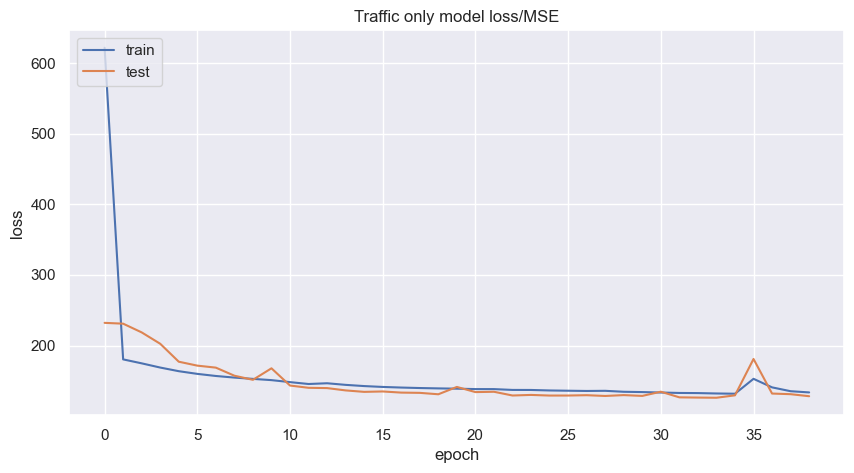

In [55]:
def summarize_history_loss(history, title):
    # summarize history for Loss/MSE
    fig_acc = plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

summarize_history_loss(history, 'Traffic only model loss/MSE')

In [56]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

312/312 - 1s - 5ms/step - loss: 164.9719 - mse: 164.9719

MSE: 164.97189331054688


312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


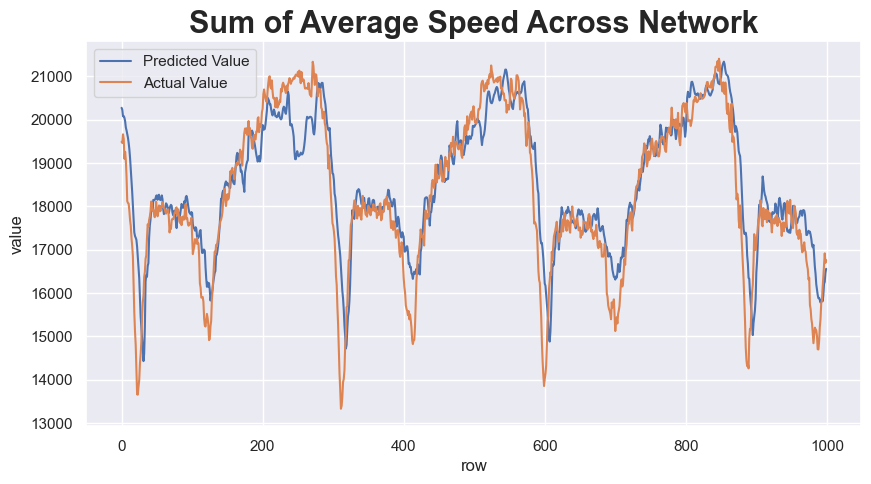

In [57]:
def plot_prediction_across_network(model, val_arrays, val_labs, title):
    y_pred_test = model.predict(val_arrays)
    y_true_test = val_labs

    # aggregating for easier visualization
    y_pred_dv = [row.sum() for row in y_pred_test]
    y_true_dv = [row.sum() for row in y_true_test]

    start = 5000
    ts = 1000

    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_dv[start:start+ts], label='Predicted Value')
    plt.plot(y_true_dv[start:start+ts], label='Actual Value')
    plt.title(title,
            fontsize=22, fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend()
    plt.show()

plot_prediction_across_network(model, val_arrays, val_labs, 'Sum of Average Speed Across Network')

## Alternative 2: Adding pollution features


In [58]:
pollution_df = pd.read_csv("../data/aarhus_pollution_data_aug_oct_2014.csv")
pollution_df['timestamp'] = pd.to_datetime(pollution_df['timestamp'])
pollution_df.set_index('timestamp', inplace=True)
pollution_df.head()

,Unnamed: 0,ozone,particullate_matter,carbon_monoxide,sulfure_dioxide,nitrogen_dioxide,longitude,latitude
timestamp,,,,,,,,
2014-08-01 00:05:00,0,101,94,49,44,87,10.104986,56.231721
2014-08-01 00:10:00,1,106,97,48,47,86,10.104986,56.231721
2014-08-01 00:15:00,2,107,95,49,42,85,10.104986,56.231721
2014-08-01 00:20:00,3,103,90,51,44,87,10.104986,56.231721
2014-08-01 00:25:00,4,105,94,49,39,82,10.104986,56.231721


In [59]:
pollution_features = ["particullate_matter", "carbon_monoxide", "sulfure_dioxide", "nitrogen_dioxide"]
# Merge using nearest timestamps 
combined_pollution_traffic = pd.merge_asof(
    traffic_df.sort_index(),
    pollution_df[pollution_features].sort_index(),
    left_index=True,
    right_index=True,
    direction='nearest'
)

combined_pollution_traffic

,610,611,612,613,614,615,616,617,618,619,...,1053,1054,1055,1056,1057,1058,particullate_matter,carbon_monoxide,sulfure_dioxide,nitrogen_dioxide
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,19.0,48.0,34.0,0.0,65.0,32.000000,43,49,39,90
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,21.0,69.0,34.0,0.0,69.0,32.000000,33,86,76,73
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,21.0,70.0,36.0,0.0,67.0,28.000000,31,34,68,123
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,22.0,56.0,46.0,0.0,58.0,28.000000,91,37,79,106
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,22.0,51.0,46.0,0.0,60.0,27.666667,31,39,48,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-13 10:25:00,42.0,12.0,52.0,40.0,33.0,52.5,45.0,36.5,30.0,44.0,...,0.0,60.0,48.0,44.0,63.0,26.000000,190,193,126,105
2014-11-13 10:30:00,42.0,12.0,52.0,32.0,33.0,75.0,40.0,37.0,29.0,44.0,...,0.0,70.0,41.0,44.0,63.0,23.000000,190,193,126,105
2014-11-13 10:35:00,50.0,12.0,44.0,36.0,41.0,49.0,55.0,37.0,35.0,44.0,...,0.0,69.0,42.0,44.0,65.0,23.000000,190,193,126,105


In [60]:
training_sample = combined_pollution_traffic[100:20000]
validation_sample = combined_pollution_traffic[20001:]

combined_pollution_traffic.shape

(29984, 453)

In [61]:
# set predictive horizon and sequence length
ph = 5
seq_length = 12

# features to randomly sample without replacement
# must be a value between 1 to 449, inclusive 

input_features = 453 
output_features = 449

sensor = pd.Series(training_sample.columns).sample(
    input_features, replace=False).sort_values().to_list()


seq_arrays, seq_labs = create_sequence_training_set(training_sample, seq_length, ph,input_features, output_features)

val_arrays, val_labs = create_validation_set(validation_sample, seq_length, ph, input_features, output_features)

In [62]:


model, history = train_lstm_model('lstm_traffic_pollution.keras',
                                  seq_length,
                                  seq_arrays,
                                  seq_labs,
                                  input_features, 
                                  output_features)
# list all data in history
print(history.history.keys())

/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 12, 100)        │       221,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 12, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 449)            │        14,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,073 (1.11 MB)

 Trainable params: 291,073 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
237/237 - 7s - 29ms/step - loss: 1062.7853 - mse: 1062.7854 - val_loss: 233.0551 - val_mse: 233.0551
Epoch 2/1000
237/237 - 5s - 23ms/step - loss: 204.6843 - mse: 204.6843 - val_loss: 229.9235 - val_mse: 229.9235
Epoch 3/1000
237/237 - 5s - 23ms/step - loss: 187.9513 - mse: 187.9513 - val_loss: 232.0305 - val_mse: 232.0305
Epoch 4/1000
237/237 - 6s - 23ms/step - loss: 289.6569 - mse: 289.6569 - val_loss: 233.6432 - val_mse: 233.6432
Epoch 5/1000
237/237 - 6s - 23ms/step - loss: 182.3024 - mse: 182.3024 - val_loss: 228.3916 - val_mse: 228.3916
Epoch 6/1000
237/237 - 6s - 23ms/step - loss: 178.6523 - mse: 178.6523 - val_loss: 225.8599 - val_mse: 225.8599
Epoch 7/1000
237/237 - 5s - 23ms/step - loss: 177.7801 - mse: 177.7801 - val_loss: 223.6024 - val_mse: 223.6024
Epoch 8/1000
237/237 - 5s - 23ms/step - loss: 176.1100 - mse: 176.1100 - val_loss: 215.5748 - val_mse: 215.5748
Epoch 9/1000
237/237 - 5s - 22ms/step - loss: 175.1578 - mse: 175.1578 - val_loss: 207.0841 - val

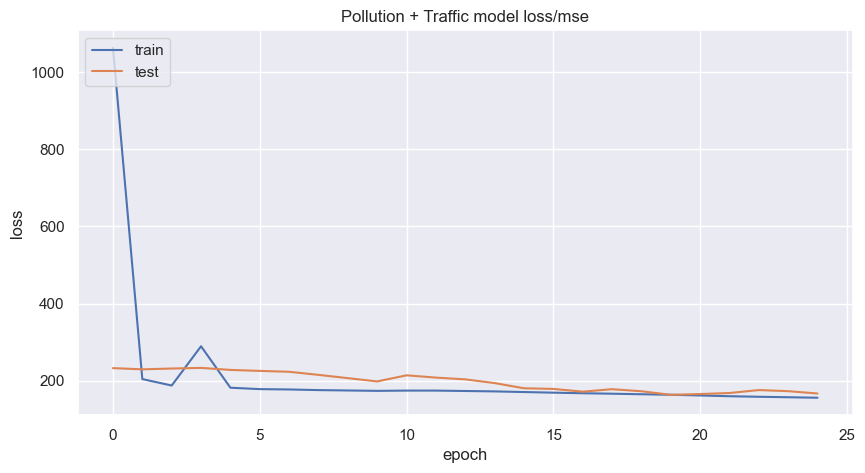

312/312 - 1s - 5ms/step - loss: 194.9275 - mse: 194.9275

MSE: 194.92752075195312


In [63]:
summarize_history_loss(history, "Pollution + Traffic model loss/mse")

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


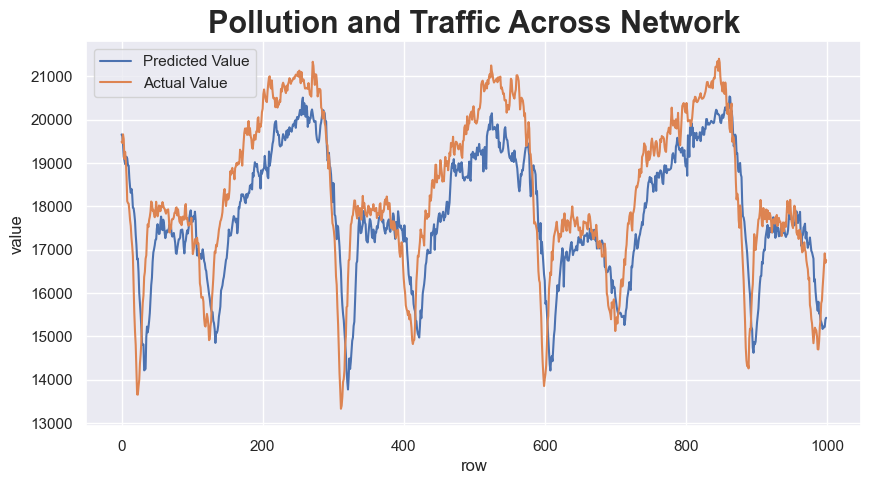

In [64]:
plot_prediction_across_network(model, val_arrays, val_labs, 'Pollution and Traffic Across Network')

# Alternative 3: Parking information

In [65]:
parking_df = pd.read_csv("../data/aarhus_parking_geolocated.csv")
parking_df['updatetime'] = pd.to_datetime(parking_df['updatetime'], format='mixed')
parking_df.set_index('updatetime', inplace=True)
parking_df.head()

,Unnamed: 0,vehiclecount,_id,totalspaces,garagecode,streamtime,latitude,longitude,address
updatetime,,,,,,,,,
2014-05-22 09:09:04.145,0,0,1,65,NORREPORT,2014-11-03 16:18:44,56.162023,10.211065,"Nørreport, Aarhus, Aarhus Kommune, Region Midt..."
2014-05-22 09:09:04.145,1,0,2,512,SKOLEBAKKEN,2014-11-03 16:18:44,56.157146,10.213121,"Skolebakken, Aarhus, Aarhus Kommune, Region Mi..."
2014-05-22 09:09:04.145,2,869,3,1240,SCANDINAVIAN CENTER,2014-11-03 16:18:44,56.152770,10.197070,"Scandinavian Center Aarhus, Skovgaardsgade, Fr..."
2014-05-22 09:09:04.145,3,22,4,953,BRUUNS,2014-11-03 16:18:44,56.149019,10.204733,"Bruuns Galleri, Værkmestergade, Midtbyen, Fred..."
2014-05-22 09:09:04.145,4,124,5,130,BUSGADEHUSET,2014-11-03 16:18:44,56.155552,10.206232,"Busgadehuset, Busgaden, Midtbyen, Frederiksbje..."


In [66]:
# following shauns suggestion
parking_df_aggregated = parking_df.groupby(parking_df.index).agg({
    'vehiclecount': 'sum',
    'totalspaces': 'sum'
})

parking_df_aggregated['occupancy_rate'] = parking_df_aggregated['vehiclecount'] / parking_df_aggregated['totalspaces']

In [67]:
parking_features = ['occupancy_rate']
# Merge using nearest timestamps 
combined_parking_traffic = pd.merge_asof(
    traffic_df.sort_index(),
    parking_df_aggregated[parking_features].sort_index(),
    left_index=True,
    right_index=True,
    direction='nearest'
)

combined_parking_traffic

,610,611,612,613,614,615,616,617,618,619,...,1050,1051,1052,1053,1054,1055,1056,1057,1058,occupancy_rate
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,20.0,21.0,50.0,19.0,48.0,34.0,0.0,65.0,32.000000,0.298812
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,35.0,21.0,50.0,21.0,69.0,34.0,0.0,69.0,32.000000,0.298812
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,35.0,21.0,50.0,21.0,70.0,36.0,0.0,67.0,28.000000,0.337530
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,37.0,21.0,57.0,22.0,56.0,46.0,0.0,58.0,28.000000,0.337530
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,23.0,14.0,57.0,22.0,51.0,46.0,0.0,60.0,27.666667,0.337530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-13 10:25:00,42.0,12.0,52.0,40.0,33.0,52.5,45.0,36.5,30.0,44.0,...,22.0,29.0,49.0,0.0,60.0,48.0,44.0,63.0,26.000000,0.726841
2014-11-13 10:30:00,42.0,12.0,52.0,32.0,33.0,75.0,40.0,37.0,29.0,44.0,...,27.0,29.0,55.0,0.0,70.0,41.0,44.0,63.0,23.000000,0.726841
2014-11-13 10:35:00,50.0,12.0,44.0,36.0,41.0,49.0,55.0,37.0,35.0,44.0,...,27.0,23.0,55.0,0.0,69.0,42.0,44.0,65.0,23.000000,0.726841


In [68]:
training_sample = combined_parking_traffic[100:20000]
validation_sample = combined_parking_traffic[20001:]

combined_parking_traffic.shape

(29984, 450)

In [69]:
# set predictive horizon and sequence length
ph = 5
seq_length = 12

# features to randomly sample without replacement
# must be a value between 1 to 449, inclusive 
#features = 451

input_features = 450 
output_features = 449

sensor = pd.Series(training_sample.columns).sample(
    input_features, replace=False).sort_values().to_list()


seq_arrays, seq_labs = create_sequence_training_set(training_sample, seq_length, ph, input_features, output_features)

val_arrays, val_labs = create_validation_set(validation_sample, seq_length, ph, input_features, output_features)

In [70]:


model, history = train_lstm_model('lstm_traffic_parking.keras',
                                  seq_length,
                                  seq_arrays,
                                  seq_labs,
                                  input_features,
                                  output_features)
# list all data in history
print(history.history.keys())

/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 12, 100)        │       220,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 12, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 449)            │        14,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,873 (1.11 MB)

 Trainable params: 289,873 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
237/237 - 7s - 30ms/step - loss: 735.3107 - mse: 735.3107 - val_loss: 230.8700 - val_mse: 230.8700
Epoch 2/1000
237/237 - 5s - 22ms/step - loss: 187.4741 - mse: 187.4741 - val_loss: 229.7125 - val_mse: 229.7125
Epoch 3/1000
237/237 - 5s - 22ms/step - loss: 181.4239 - mse: 181.4239 - val_loss: 232.8613 - val_mse: 232.8613
Epoch 4/1000
237/237 - 5s - 22ms/step - loss: 178.5844 - mse: 178.5844 - val_loss: 231.6178 - val_mse: 231.6178
Epoch 5/1000
237/237 - 5s - 23ms/step - loss: 176.8232 - mse: 176.8232 - val_loss: 227.9369 - val_mse: 227.9369
Epoch 6/1000
237/237 - 5s - 22ms/step - loss: 174.5805 - mse: 174.5805 - val_loss: 216.6569 - val_mse: 216.6569
Epoch 7/1000
237/237 - 5s - 22ms/step - loss: 172.5797 - mse: 172.5797 - val_loss: 212.9892 - val_mse: 212.9892
Epoch 8/1000
237/237 - 5s - 22ms/step - loss: 175.4927 - mse: 175.4927 - val_loss: 208.9139 - val_mse: 208.9139
Epoch 9/1000
237/237 - 5s - 22ms/step - loss: 170.5502 - mse: 170.5502 - val_loss: 203.3014 - val_m

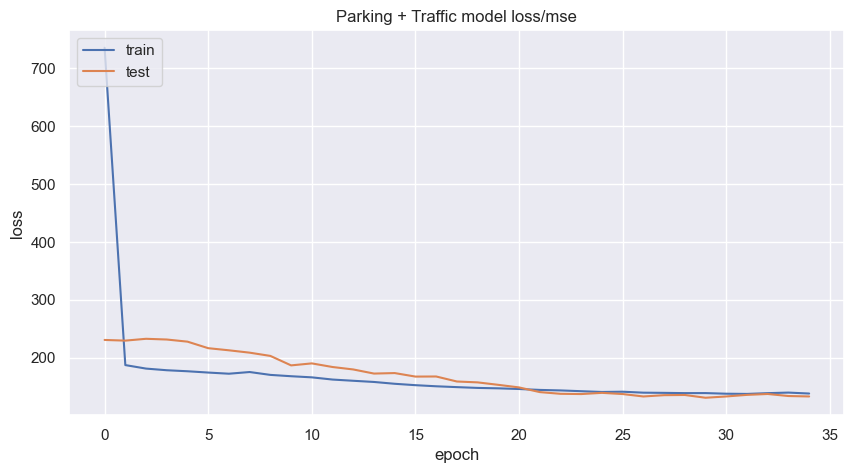

312/312 - 1s - 4ms/step - loss: 171.9937 - mse: 171.9937

MSE: 171.9936981201172


In [71]:
summarize_history_loss(history, "Parking + Traffic model loss/mse")

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


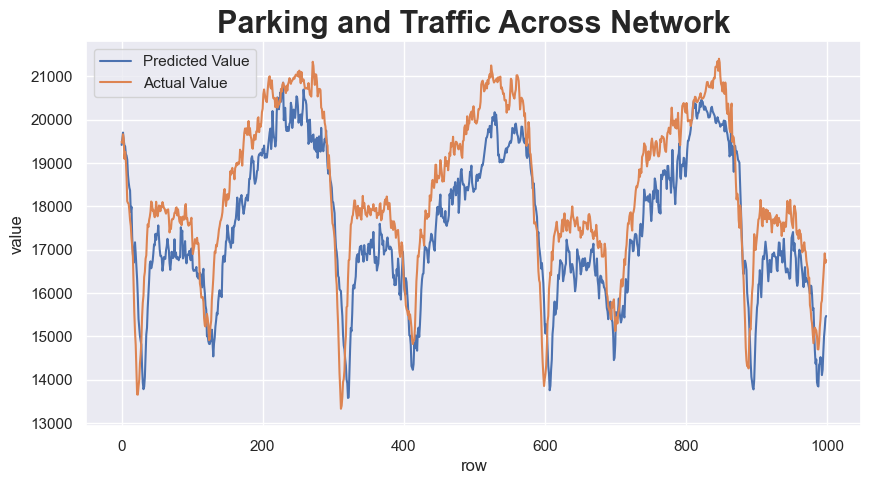

In [72]:
plot_prediction_across_network(model, val_arrays, val_labs, 'Parking and Traffic Across Network')